<a href="https://colab.research.google.com/github/larissazoraida/Diplomado-Python/blob/main/Ajuste_y_Extension_de_Curvas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os
import gspread
from gspread_dataframe import get_as_dataframe
from google.auth import default
from google.colab import auth
#yo importo todo lo que alguna vez use por si acaso

# Autenticacion de usuario
auth.authenticate_user()
creds, _ = default()
# Initialize gspread client
gc = gspread.authorize(creds)


In [ ]:
# Conectamos a Google Drive
drive.mount('/content/gdrive')
# Establecemos el directorio de trabajo (donde se guardaran los descargables)
os.chdir('/content/gdrive/MyDrive/Datos de Colab/Proyecto de Proyeccion')

Inicio de la consulta

In [63]:
# Abrir el archivo de GoogleSheets
spreadsheet = gc.open_by_key('1fNlj_8cNgDJyFp4LSJJrgvoqZVHSUvJl1hply4Pty24')
worksheet = spreadsheet.worksheet('Base de Curvas')
data = get_as_dataframe(worksheet)
df=data.copy() # creo una copia para trabajar sobre df y referirme a data cuado quiera comprobar integridad de datos
display(len(df))
display(df['Fecha certificado'].isna().sum())
#tabla original 16883 datos

16883

np.int64(4662)

In [65]:
#cambio el nombre de las columnas ya que me es mas facil trabajar sin acentos y otros.
df.rename({'Operación':'Operacion',
           'Dirección':'Direccion',
           'Fecha certificado':'Fecha acta',
           'Informe técnico':'Informe tecnico',
           'Fecha cert. confirmacion':'Fecha confirmacion'},
           axis=1, inplace=True)
#list(df.columns)
display(len(df))
display(df['Fecha acta'].isna().sum())

16883

np.int64(4662)

In [ ]:
df.info()

In [66]:
#df.columns
strings = ['#', 'Operacion', 'Direccion', 'Unidad', 'Oferente adjudicado',
       'Contrato', 'Tramo', 'Lote',
       'Fec. orden inicio', 'Fec. finaliz. vig.', 'Estado contractual',
       'Mes', 'Etapa', 'Fecha acta', 'Fecha confirmacion',
       'Estado certificado', 'Informe tecnico',
       'Nro. MEU', 'Fecha MEU']

In [67]:
# Convertir a strings
df[strings] = df[strings].astype(str)

In [68]:

#cambiar valores problematicos
cond1= (df['#']=='8') & (df['Operacion']=='Obra_887')
cond2= (df['#']=='13') & (df['Operacion']=='Obra_2247')
cond3= (df['#']=='2') & (df['Operacion']=='Obra_1298')
opciones=['22/10/2014','25/03/2023','31/08/2019']

df['Fecha acta'] = np.select([cond1, cond2, cond3], opciones, df['Fecha acta'])
#select funciona como un where, verifica y reescribe todos los valores, es decir
#existe un else


In [69]:
#transformacion a tipo fecha de todas las fechas
variables_fecha=['Fecha acta', 'Fecha confirmacion','Fecha MEU', 'Fec. orden inicio','Fec. finaliz. vig.']

for col in variables_fecha:
    df[col] = pd.to_datetime(df[col], errors='coerce', format='%d/%m/%Y')

display(len(df))

16883

In [70]:
df['Año MEU']= df['Fecha MEU'].dt.year
df['Año MEU']
#datos con error en el anho
meus = ['1251/','1252/','5847/','44205/2025','2156/','40045/2022','13289/2025','112/2025', '4473/']
condicion = df['Nro. MEU'].isin(meus)
df.loc[condicion,'Año MEU'] = 2025
# convertir
df['Año MEU'] = df['Año MEU'].fillna(0).astype(int)

In [ ]:
for x in  variables_fecha:
  display(x,df[x].isna().sum())

In [ ]:
variables_fecha2=['Fecha certificado', 'Fecha cert. confirmacion','Fecha MEU', 'Fec. orden inicio','Fec. finaliz. vig.']
for x in  variables_fecha2:
  display(x,data[x].isna().sum())

In [ ]:
#verif Fecha meu
cond = (df['Fecha MEU'].isna()) & (~data['Fecha MEU'].isna())

data[['#','Operación','Nro. MEU','Fecha MEU']][cond]

Pasar directamente al reajuste de Fecha de finalizacion por deteccion de avance en la curva programada. Corriendo fecha desde hoy


In [71]:
from datetime import timedelta

In [72]:
#primero debo seleccionar con que curvas trabajar ya que en la base de curvas
#hay un monton de curvas culminadas, paralizadas etc
#Excluir todo lo que es con mantenimiento
selected = [
'342/2024']
df = df[data['Contrato'].isin(selected)]
#'208/2023',
#,'5/2025'

In [73]:
#la extension sera a partir de la fecha de hoy


def extension_curvas(df):

    df = df.sort_values(by=['Operacion', 'Porcent. prog. acum.']).reset_index(drop=True)

    df_extendido = []

    # Agrupar por 'Operacion' para procesar cada curva independientemente
    for curve_id, group in df.groupby('Operacion'):
        max_ejecucion = group['Porcent. ejec. acum.'].max()
        curva_nueva = [] #lista para guardar los nuevos puntos
        avance_previo = 0

        for i in range(len(group)):
            datos_operacion = group.iloc[i]
            avance_actual = datos_operacion['Porcent. prog. acum.']

            diff_avance = (avance_actual - avance_previo) / 3

            curva_nueva.append(avance_previo + diff_avance)
            curva_nueva.append(avance_previo + (diff_avance * 2))
            curva_nueva.append(avance_actual)

            avance_previo = avance_actual

        # Generamos las fechas iniciando por hoy y agregando 15 dias(esto es..
        #para lograr la expension de la curva)
        fechai = pd.to_datetime('today')+timedelta(days=15)

        for j in range(len(curva_nueva)):
            if curva_nueva[j] >= max_ejecucion:
                df_extendido.append({
                    'Operacion': curve_id,
                    'Max_ejecucion': max_ejecucion,
                    'Fecha_extendida': fechai,
                    'Prog_acum_nuevo': curva_nueva[j]
                })
                fechai = fechai+timedelta(days=15)
    return pd.DataFrame(df_extendido).sort_values(by=['Operacion', 'Fecha_extendida']).reset_index(drop=True)


df_extendido = extension_curvas(df.copy())
print("Proyeccion extendida:")
df_extendido.head(100)

Proyeccion extendida:


,Operacion,Max_ejecucion,Fecha_extendida,Prog_acum_nuevo
0,Obra_2871,35.09,2025-11-22 01:15:34.125489,36.666667
1,Obra_2871,35.09,2025-12-07 01:15:34.125489,38.333333
2,Obra_2871,35.09,2025-12-22 01:15:34.125489,40.000000
3,Obra_2871,35.09,2026-01-06 01:15:34.125489,41.666667
4,Obra_2871,35.09,2026-01-21 01:15:34.125489,43.333333
5,Obra_2871,35.09,2026-02-05 01:15:34.125489,45.000000
6,Obra_2871,35.09,2026-02-20 01:15:34.125489,46.666667
7,Obra_2871,35.09,2026-03-07 01:15:34.125489,48.333333
8,Obra_2871,35.09,2026-03-22 01:15:34.125489,50.000000
9,Obra_2871,35.09,2026-04-06 01:15:34.125489,51.666667


In [74]:
df_extendido.groupby('Operacion').agg('count')

,Max_ejecucion,Fecha_extendida,Prog_acum_nuevo
Operacion,,,
Obra_2871,39,39,39


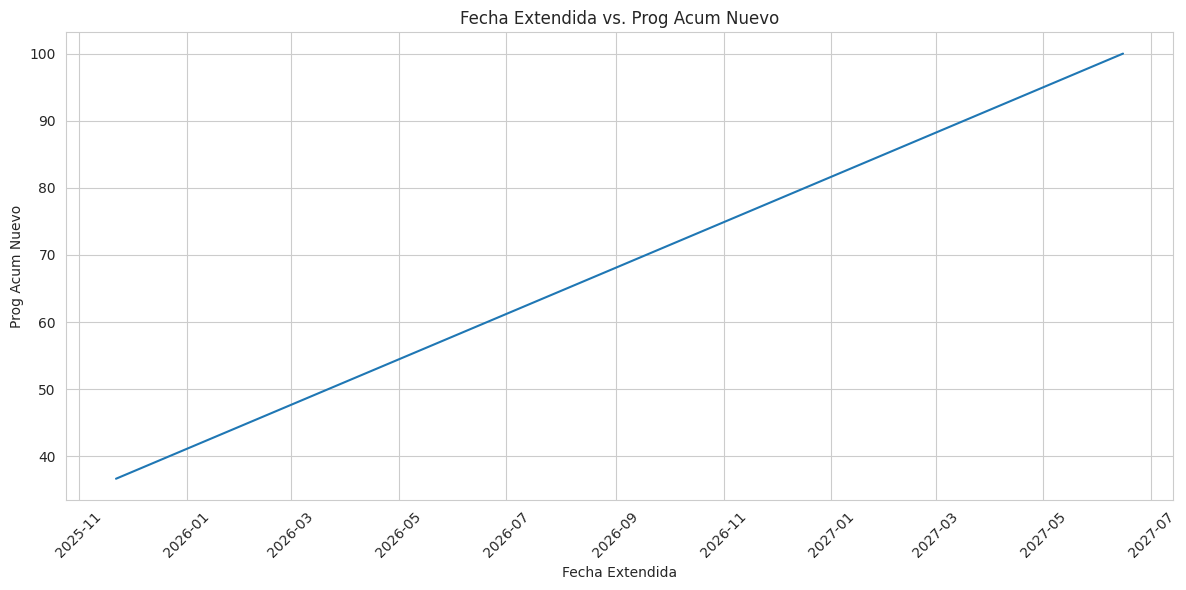

In [75]:

sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_extendido, x='Fecha_extendida', y='Prog_acum_nuevo')

plt.title('Fecha Extendida vs. Prog Acum Nuevo')
plt.xlabel('Fecha Extendida')
plt.ylabel('Prog Acum Nuevo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

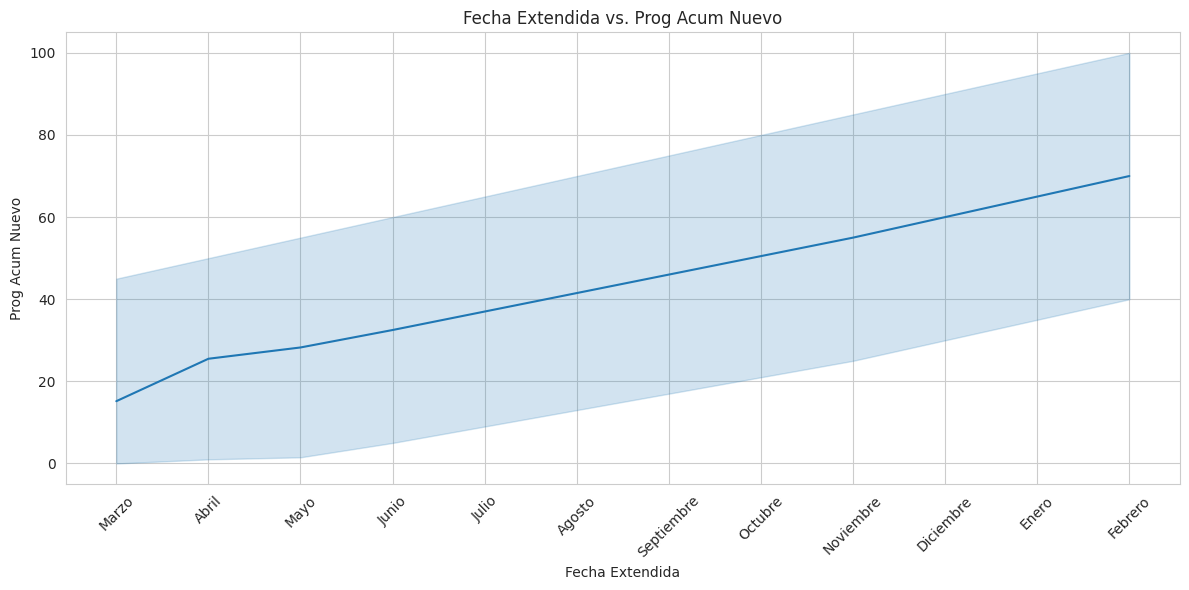

In [76]:
df.sort_values(by=['Operacion', 'Porcent. prog. acum.']).reset_index(drop=True)

sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Mes', y='Porcent. prog. acum.')

plt.title('Fecha Extendida vs. Prog Acum Nuevo')
plt.xlabel('Fecha Extendida')
plt.ylabel('Prog Acum Nuevo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()